# **Code for Video-Based Fall Detection with Deep SpatialTemporal models**

All the code was deployed on Google Colab, notebook style, run on NVIDIA A100 GPU.

The Up-Fall dataset could be found on https://sites.google.com/up.edu.mx/har-up/. Downloaded and placed in the folder "dataset"

## **Content**

* **0. Install Packages**

* **1. Dataset Preprocessing**

* **2. Model Difinition**

* **3. Training and Evaluation**

* **4. Results VIsualisation**


## **Repo Content**
- smarthomefalldetection/
  - smarthomefalldetction.ipynb/
  - results/
  - dataset/
    - subject1/
    - subject2/

    - ....
  - datasets/
    - npz/
      - subject....npz/
      - ....
    - inference/

# **0. Install Packages**

In [ ]:
import os
import zipfile
import glob
import json
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import random
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import timm

# **1. Dataset Processing**

In [ ]:
# The dataset was uploaded to Google Colab in .zip format.
# Following lines used for zipfile extraction
base_root = '/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset'

for subject_id in range(1, 18):
    root_path = os.path.join(base_root, f'subject{subject_id}')
    print(f'\nProcessing: {root_path}')

    for foldername, subfolders, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.endswith('.zip'):
                zip_path = os.path.join(foldername, filename)
                unzip_folder = os.path.join(foldername, filename[:-4]) # [:-4] -> .zip

                if not os.path.exists(unzip_folder):
                    os.makedirs(unzip_folder)
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(unzip_folder)
                    print(f'Unzipped: {zip_path} → {unzip_folder}')
                else:
                    print(f'Skipped (already exists): {unzip_folder}')


In [ ]:
# Load dataset from path
# Each datapoint is: [datapath, label, trialpath]
def load_dataset(root_path):
    data = []

    # All activities were divided into falls or ADLs
    fall_ids = [1, 2, 3, 4, 5, 6]
    adl_ids = [7, 8, 9, 10, 11]

    for subject_folder in sorted(os.listdir(root_path)):
        subject_path = os.path.join(root_path, subject_folder)
        if not os.path.isdir(subject_path):
            continue

        activity_seen = set()

        for trial_folder in sorted(os.listdir(subject_path)):
            trial_path = os.path.join(subject_path, trial_folder)
            if not os.path.isdir(trial_path):
                continue

            # Filnames like: ...ActivityXTrialY...
            parts = trial_folder.split('Activity')
            if len(parts) < 2 or 'Trial' not in parts[1]:
                continue

            try:
                # get the activity_id part (parts[1])
                activity_id = int(parts[1].split('Trial')[0])
            except ValueError:
                continue

            if activity_id not in activity_seen:
                activity_seen.add(activity_id)

            # Define label as Fall or ADL
            label = 'fall' if activity_id in fall_ids else 'adl'
            frame_paths = sorted(glob.glob(os.path.join(trial_path, '*.png')))

            data.append({
                'frames': frame_paths,
                'label': label,
                'path': trial_path
            })

    return data

In [ ]:
# Load dataset, but without activity2. Mostly the same as above
def load_dataset(root_path):
    data = []

    fall_ids = [1, 2, 3, 4, 5, 6]
    adl_ids = [7, 8, 9, 10, 11]

    for subject_folder in sorted(os.listdir(root_path)):
        subject_path = os.path.join(root_path, subject_folder)
        if not os.path.isdir(subject_path):
            continue

        activity_seen = set()

        for trial_folder in sorted(os.listdir(subject_path)):
            trial_path = os.path.join(subject_path, trial_folder)
            if not os.path.isdir(trial_path):
                continue

            parts = trial_folder.split('Activity')
            if len(parts) < 2 or 'Trial' not in parts[1]:
                continue

            try:
                activity_id = int(parts[1].split('Trial')[0])
            except ValueError:
                continue

            # Extract acitivity2
            if activity_id == 2:
                continue

            if activity_id not in activity_seen:
                activity_seen.add(activity_id)

            label = 'fall' if activity_id in fall_ids else 'adl'
            frame_paths = sorted(glob.glob(os.path.join(trial_path, '*.png')))

            data.append({
                'frames': frame_paths,
                'label': label,
                'path': trial_path
            })

    return data

In [ ]:
dataset_root = "/content/drive/MyDrive/Colab Notebooks/smarthomefalldetection/dataset"
data = load_dataset(dataset_root)

In [ ]:
# Loading dataframes one by one requires multiple I/O
# Therefore,  making them all into a .npz file(one per video)

# Transform into 64*64
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

def save_trial_as_npz(trial_path, output_dir, max_frames=None):
    import re

    frame_files = sorted([f for f in os.listdir(trial_path) if f.endswith('.png')])
    frames = []

    for fname in frame_files:
        img_path = os.path.join(trial_path, fname)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        frames.append(img_tensor.numpy())

    valid_len = len(frames)

    if max_frames is not None:
        if valid_len > max_frames:
            frames = frames[:max_frames] # Keep the first [max_frames] frames
            mask = np.ones(max_frames, dtype=np.uint8) # mask all 1 (1 means valid)
        else:
            pad_num = max_frames - valid_len
            frames += [frames[-1]] * pad_num # Use the last frame to do padding
            mask = np.zeros(max_frames, dtype=np.uint8)
            mask[:valid_len] = 1 # mask all 1 for non_padded frames
    else:
        mask = np.ones(valid_len, dtype=np.uint8) # Or, just 1 for all

    # Stack the frames together
    video_array = np.stack(frames)  # [T, C, H, W]

    activity_id = int(re.search(r'Activity(\d+)', trial_path).group(1))
    label = 0 if activity_id in [7, 8, 9, 10, 11] else 1 # Assign labels

    os.makedirs(output_dir, exist_ok=True)
    basename = os.path.basename(trial_path)
    # Every .npz consists of frame sequences, masks, labels
    np.savez(os.path.join(output_dir, f"{basename}.npz"), video=video_array, mask=mask, label=label)

def generate_npz_cache(all_data, output_dir, max_frames=None):
    for item in tqdm(all_data, desc="Generating NPZ files"):
        save_trial_as_npz(item['path'], output_dir, max_frames=max_frames)


In [ ]:
# This part for checking missing trials
root_dir = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/"

trial_dirs = sorted(glob(os.path.join(root_dir, "subject*/Subject*Activity*Trial*Camera*")))
all_data = [{'path': p} for p in trial_dirs]
print(f"Found {len(all_data)} trial folders.")

Found 267 trial folders.
Example: {'path': '/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/subject1/Subject1Activity1Trial1Camera1'}


In [ ]:
# Read all data at one time, then make them into a .npz list
import os
import numpy as np

def build_npz_data_list(npz_dir):
    data_list = []
    for fname in os.listdir(npz_dir):
        if fname.endswith(".npz"):
            npz_path = os.path.join(npz_dir, fname)
            try:
                npz = np.load(npz_path)
                label_value = int(npz['label'])  # get label
                label_str = 'adl' if label_value == 0 else 'fall' # (0, 1) to str
                # add to dict
                data_list.append({
                    'npz_path': npz_path,
                    'label': label_str
                })
            except Exception as e:
                print(f"Skipping {fname} ：{e}")
    print(f"Len of data: {len(data_list)}")
    return data_list

output_npz_dir = '/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/npz_300'
generate_npz_cache(all_data, output_dir=output_npz_dir, max_frames=300)

In [ ]:
# This part is for checking the npz list, whether it has video, mask and label,
# as well as the shape of frames
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image
import torch

def verify_npz_folder_with_preview(npz_dir, sample_count=5):
    npz_files = [f for f in os.listdir(npz_dir) if f.endswith('.npz')]

    print(f"{len(npz_files)} .npz files，sample:{sample_count}")

    # check first [sample_count] samples
    for i, fname in enumerate(npz_files[:sample_count]):
        npz_path = os.path.join(npz_dir, fname)
        try:
            npz = np.load(npz_path)

            assert 'video' in npz and 'mask' in npz and 'label' in npz, "losing key attr"
            video = npz['video']   # [T, C, H, W]
            mask = npz['mask']     # [T]
            label = npz['label']   # int

            assert video.ndim == 4, f"video dim incorrect: {video.shape}"
            assert mask.ndim == 1, f"mask dim incorrect: {mask.shape}"
            assert video.shape[0] == mask.shape[0], f"T dim incorrect: video {video.shape[0]} vs mask {mask.shape[0]}"
            assert isinstance(label.item(), (int, np.integer)), f"label format incorrect: {label}"

            print(f"{fname} checked | video: {video.shape}, mask: {mask.shape}, label: {label}")

            #  show first frame of the sequence
            if i == 0:
                first_frame = video[0]  # [C, H, W]
                first_frame_pil = F.to_pil_image(torch.tensor(first_frame))
                plt.imshow(first_frame_pil)
                plt.title(f"{fname} - first frame of the suquence（Label: {'Fall' if label == 1 else 'ADL'}）")
                plt.axis("off")
                plt.show()

        except Exception as e:
            print(f"{fname} error: {e}")

verify_npz_folder_with_preview("/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/npz", sample_count=250)

In [ ]:
npz_data = build_npz_data_list(output_npz_dir)

Len of data: 204


In [ ]:
# Pytorch dataset

class NPZVideoDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, label_map={'adl': 0, 'fall': 1}):
        self.data_list = data_list
        self.label_map = label_map

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        npz = np.load(item['npz_path'])

        video = torch.tensor(npz['video'], dtype=torch.float32)     # [T, C, H, W]
        mask = torch.tensor(npz['mask'], dtype=torch.bool)          # [T]
        label = torch.tensor(self.label_map[item['label']], dtype=torch.long)

        length = mask.sum().item()

        return video, length, label, item['npz_path']


In [ ]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    videos, lengths, labels, paths= zip(*batch)  # tuple of Tensors
    videos = [v for v in videos]  #  [T, C, H, W] Each. Make it into a list
    max_len = max([v.shape[0] for v in videos]) # Get max length in the video sequence
    padded_videos = []
    for v in videos:
        pad_len = max_len - v.shape[0]
        if pad_len > 0:
            pad = v[-1:].repeat(pad_len, 1, 1, 1)  # repeat last frame
            v = torch.cat([v, pad], dim=0) # concatenate
        padded_videos.append(v)

    videos_tensor = torch.stack(padded_videos)  # [B, T, C, H, W]
    # To tensor
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return videos_tensor, lengths_tensor, labels_tensor, paths


In [ ]:
# K-fold validation
def split_subjects_kfold(data, k=4, seed=23):
    # Extract subject_id
    all_subjects = sorted(list(set([
        re.search(r'subject\d+', item['npz_path'], re.IGNORECASE).group(0)
        for item in data
    ])))

    kf = KFold(n_splits=k, shuffle=True, random_state=seed) # use torch KFold
    folds = []
    # Split train and test set
    for train_idx, test_idx in kf.split(all_subjects):
        train_subjects = [all_subjects[i] for i in train_idx]
        test_subjects = [all_subjects[i] for i in test_idx]

        train_data, test_data = [], []
        for item in data:
            subject_id = re.search(r'subject\d+', item['npz_path'], re.IGNORECASE).group(0)
            # Add to each set from data
            if subject_id in train_subjects:
                train_data.append(item)
            else:
                test_data.append(item)
        folds.append((train_data, test_data))
    return folds

In [ ]:
# Random Split. Used for initial model test.
# Because K-Fold requires a large amount of training time
# train: val : test -> 7 : 0.15 : 2.85
def split_data_by_subject(data, train_ratio=0.7, val_ratio=0.15, seed=23):
    all_subjects = set([
        re.search(r'subject\d+', item['npz_path'], re.IGNORECASE).group(0)
        for item in data
    ])

    all_subjects = sorted(list(all_subjects))
    random.seed(seed)
    random.shuffle(all_subjects)

    n_total = len(all_subjects)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    train_subjects = set(all_subjects[:n_train])
    val_subjects = set(all_subjects[n_train:n_train + n_val])
    test_subjects = set(all_subjects[n_train + n_val:])

    train_data, val_data, test_data = [], [], []

    for item in data:
        subject_id = re.search(r'subject\d+', item['npz_path'], re.IGNORECASE).group(0)
        if subject_id in train_subjects:
            train_data.append(item)
        elif subject_id in val_subjects:
            val_data.append(item)
        else:
            test_data.append(item)

    return train_data, val_data, test_data


In [ ]:
# Dataloader using random split
from torch.utils.data import DataLoader

train_data, val_data, test_data = split_data_by_subject(npz_data, train_ratio=0.7, val_ratio=0.15)

train_dataset = NPZVideoDataset(train_data)
val_dataset   = NPZVideoDataset(val_data)
test_dataset  = NPZVideoDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True,
                          collate_fn=collate_fn)

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=collate_fn)

test_loader = DataLoader(test_dataset, batch_size=2,
                         num_workers=4, pin_memory=True,
                         collate_fn=collate_fn)


# **2. Models**

In [ ]:
#Resnet18 + LSTM
class ResNetLSTMClassifier(nn.Module):
    def __init__(self, cnn_feature_dim=512, lstm_hidden_dim=128, lstm_layers=2, num_classes=2):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]  # Drop the original FC (which is for imagenet)
        self.cnn = nn.Sequential(*modules)
        self.lstm = nn.LSTM(input_size=cnn_feature_dim, hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(0.1) # dropout 0.1
        self.fc = nn.Linear(lstm_hidden_dim, num_classes)

    def forward(self, x, lengths):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        cnn_feats = self.cnn(x)  # [B*T, 512, 1, 1]
        cnn_feats = cnn_feats.view(B, T, -1)  # [B, T, 512]

        packed_seq = nn.utils.rnn.pack_padded_sequence(cnn_feats, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_seq)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        last_output = torch.stack([output[i, l-1] for i, l in enumerate(lengths)])
        out = self.dropout(last_output)
        logits = self.fc(out)
        return logits

In [ ]:
#Resnet34+LSTM
class ResNet34LSTMClassifier(nn.Module):
    def __init__(self, cnn_feature_dim=512, lstm_hidden_dim=128, lstm_layers=2, num_classes=2):
        super().__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]  # Drop the original FC (That is for imagenet)
        self.cnn = nn.Sequential(*modules)
        self.lstm = nn.LSTM(input_size=cnn_feature_dim, hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(lstm_hidden_dim, num_classes)

    def forward(self, x, lengths):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        cnn_feats = self.cnn(x)  # [B*T, 512, 1, 1]
        cnn_feats = cnn_feats.view(B, T, -1)  # [B, T, 512]

        packed_seq = nn.utils.rnn.pack_padded_sequence(cnn_feats, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_seq)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        last_output = torch.stack([output[i, l-1] for i, l in enumerate(lengths)])
        out = self.dropout(last_output)
        logits = self.fc(out)
        return logits

In [ ]:
#Resnet18+LSTM+Attention
# Define Attention module
class Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Define QKV transformation
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key   = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, lengths):
        # Calculate QKV
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        # Calculate Attention scores
        attn_weights = self.softmax(torch.bmm(Q, K.transpose(1,2)) / np.sqrt(Q.size(-1)))
        context = torch.bmm(attn_weights, V)
        context = context.mean(dim=1)
        return context, attn_weights

class ResNetLSTMAttentionClassifier(nn.Module):
    def __init__(self, cnn_feature_dim=512, lstm_hidden_dim=128, lstm_layers=2, num_classes=2):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        self.lstm = nn.LSTM(input_size=cnn_feature_dim, hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.attention = Attention(lstm_hidden_dim, hidden_dim=64)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x, lengths):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        cnn_feats = self.cnn(x)
        cnn_feats = cnn_feats.view(B, T, -1)

        packed_seq = nn.utils.rnn.pack_padded_sequence(cnn_feats, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_seq)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        context, attn_weights = self.attention(output, lengths) # call attention

        out = self.dropout(context)
        logits = self.fc(out)
        return logits

In [ ]:
#MobileNet+lstm+attention (config 'pretrained' before use')
class Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key   = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, lengths):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = self.softmax(torch.bmm(Q, K.transpose(1,2)) / np.sqrt(Q.size(-1)))
        context = torch.bmm(attn_weights, V)
        context = context.mean(dim=1)
        return context, attn_weights

class MobileNetLSTMAttentionClassifier(nn.Module):
    def __init__(self, cnn_feature_dim=1280, lstm_hidden_dim=128, lstm_layers=2, num_classes=2):
        super().__init__()
        mobilenet = models.mobilenet_v2(pretrained=False)
        self.cnn = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=cnn_feature_dim, hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.attention = Attention(lstm_hidden_dim, hidden_dim=64)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x, lengths):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        cnn_feats = self.cnn(x)             # [B*T, 1280, H, W]
        cnn_feats = self.pool(cnn_feats)   # [B*T, 1280, 1, 1]

        cnn_feats = cnn_feats.view(B, T, -1)

        packed_seq = nn.utils.rnn.pack_padded_sequence(cnn_feats, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_seq)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        context, attn_weights = self.attention(output, lengths)

        out = self.dropout(context)
        logits = self.fc(out)
        return logits

In [ ]:
# MobileNet+lstm+attention (cnn_feat = 512)
# It is an attempt to shrink cnn_feat
# but the cost is to add an additional linear layer
class Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key   = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, lengths):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = self.softmax(torch.bmm(Q, K.transpose(1,2)) / np.sqrt(Q.size(-1)))
        context = torch.bmm(attn_weights, V)
        context = context.mean(dim=1)
        return context, attn_weights

class MobileNetLSTMAttentionClassifier(nn.Module):
    def __init__(self, cnn_feature_dim=512, lstm_hidden_dim=128, lstm_layers=2, num_classes=2):
        super().__init__()
        mobilenet = models.mobilenet_v2(pretrained=False)
        self.cnn = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.projector = nn.Linear(1280, cnn_feature_dim)
        self.lstm = nn.LSTM(input_size=cnn_feature_dim, hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.attention = Attention(lstm_hidden_dim, hidden_dim=64)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x, lengths):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        cnn_feats = self.cnn(x)             # [B*T, 1280, H, W]
        cnn_feats = self.pool(cnn_feats)   # [B*T, 1280, 1, 1]

        cnn_feats = cnn_feats.view(B, T, -1)  # [B, T, 1280]
        cnn_feats = self.projector(cnn_feats)  # [B, T, 512]

        packed_seq = nn.utils.rnn.pack_padded_sequence(cnn_feats, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_seq)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        context, attn_weights = self.attention(output, lengths)

        out = self.dropout(context)
        logits = self.fc(out)
        return logits

# **3. Training and Evaluation**

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch in train_loader:
        videos, lengths, labels = batch[:3]
        videos, lengths, labels = videos.to(device), lengths.to(device), labels.to(device)

        # Training
        optimizer.zero_grad()
        outputs = model(videos, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1) # Get predicted label
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Calculate avg. acc and loss
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
def evaluate(model, loader, device, mode="val", label_names=["ADL", "Fall"]):
    model.eval()
    y_true, y_pred = [], []
    misclassified_paths = []
    correct, total = 0, 0

    with torch.no_grad():
        for videos, lengths, labels, paths in loader:
            videos, lengths, labels = videos.to(device), lengths.to(device), labels.to(device)
            outputs = model(videos, lengths)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Record misclassified val samples
            for i in range(len(labels)):
              if preds[i] != labels[i]:
                  misclassified_paths.append(paths[i])

    acc = correct / total

    # If it's test mode, provide a confusion matrix.
    if mode == "test":
        report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
        cm = confusion_matrix(y_true, y_pred)
        print("Classification Report:\n")
        print(classification_report(y_true, y_pred, target_names=label_names))
        print("Confusion Matrix:")
        print(cm)

        if misclassified_paths:
            print("Misclassified Samples:")
            for path in misclassified_paths:
                print(path)
        else:
            print("No misclassified samples.")

        return acc, y_true, y_pred, report, cm
    else:
        return acc


In [ ]:
# Save training results to local,
# Including acc, loss,confusion matrix
def save_training_results(model, model_name,
                          train_losses, val_losses, test_losses,
                          train_accs, val_accs, test_accs,
                          y_true, y_pred, report, cm,
                          save_dir="results"):
    out_dir = os.path.join(save_dir, model_name)
    os.makedirs(out_dir, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(out_dir, "model.pth"))

    np.save(os.path.join(out_dir, "train_losses.npy"), np.array(train_losses))
    np.save(os.path.join(out_dir, "val_losses.npy"), np.array(val_losses))
    np.save(os.path.join(out_dir, "test_losses.npy"), np.array(test_losses))

    np.save(os.path.join(out_dir, "train_accs.npy"), np.array(train_accs))
    np.save(os.path.join(out_dir, "val_accs.npy"), np.array(val_accs))
    np.save(os.path.join(out_dir, "test_accs.npy"), np.array(test_accs))

    np.save(os.path.join(out_dir, "y_true.npy"), np.array(y_true))
    np.save(os.path.join(out_dir, "y_pred.npy"), np.array(y_pred))
    np.save(os.path.join(out_dir, "confusion_matrix.npy"), cm)

    with open(os.path.join(out_dir, "classification_report.json"), "w") as f:
        json.dump(report, f, indent=2)

    print(f"Results saved to: {out_dir}")

In [ ]:
# Training settings
def train_model(train_loader, val_loader, test_loader,
                num_epochs=25, model_name="v1", save_dir="results"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Change the model's name. Other parts remain the same
    model = MobileNetLSTMAttentionClassifier().to(device)

    # Freeze CNN part. Train attention and LSTM
    for param in model.cnn.parameters():
        param.requires_grad = False

    class_weights = torch.tensor([1.0, 1.5]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights) # CrossEntropyloss
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4) # Adam

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Training iterations. Record all accs and losses
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_acc = evaluate(model, val_loader, device, mode="val")
        val_loss = None

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val  Acc: {val_acc:.4f}")

        if epoch % 10 == 0:
            checkpoint_dir = os.path.join(save_dir, model_name, f"checkpoint_epoch_{epoch}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs
            }, os.path.join(checkpoint_dir, "checkpoint.pth"))

    test_acc, y_true, y_pred, report, cm = evaluate(model, test_loader, device, mode="test")
    test_losses = [None] * num_epochs # Test loss is not needed
    test_accs = [None] * (num_epochs - 1) + [test_acc] # The nth element is test_acc

    save_training_results(
      model=model,
      model_name=model_name,
      train_losses=train_losses,
      val_losses=val_losses,
      test_losses=test_losses,
      train_accs=train_accs,
      val_accs=val_accs,
      test_accs=test_accs,
      y_true=y_true,
      y_pred=y_pred,
      report=report,
      cm=cm,
      save_dir=save_dir
    )

    return model, (train_losses, val_losses, train_accs, val_accs)

In [ ]:
# Random split, resnet34+LSTM
model, stats = train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=20,
    model_name="v1_4.28_resnet34",
    save_dir="/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/results"  # results/v1/
)

In [ ]:
# K-Fold, resnet18+lstm+kfold
folds = split_subjects_kfold(npz_data, k=4, seed=23)

for fold_idx, (train_data, test_data) in enumerate(folds):
    print(f"Fold {fold_idx+1} / {len(folds)}")

    # train -> train + val
    n_val = int(0.15 * len(train_data)) # get val set
    val_data = train_data[:n_val]
    train_data_fold = train_data[n_val:]

    train_dataset = NPZVideoDataset(train_data_fold)
    val_dataset   = NPZVideoDataset(val_data)
    test_dataset  = NPZVideoDataset(test_data)

    # Dataloader for kfold is defined here.
    #Thought it would be better to make it into a Python method to call every time
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                              num_workers=4, pin_memory=True, drop_last=True,
                              collate_fn=collate_fn)

    val_loader = DataLoader(val_dataset, batch_size=2,
                            num_workers=4, pin_memory=True,
                            collate_fn=collate_fn)

    test_loader = DataLoader(test_dataset, batch_size=2,
                             num_workers=4, pin_memory=True,
                             collate_fn=collate_fn)

    model, stats = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=20,
        model_name=f"v1_6.17_resnet18lstm_fold_{fold_idx+1}",
        save_dir="/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/results"
    )

In [ ]:
# Training requires about a whole day.
# Connection was not always stable
# Therefore, continued training is needed

start_fold = 3 # Which fold to continue training

folds = split_subjects_kfold(npz_data, k=4, seed=23)

for fold_idx, (train_data, test_data) in enumerate(folds):
    if fold_idx < start_fold:
        print(f"Skipping Fold {fold_idx+1} / {len(folds)}")
        continue

    print(f"Fold {fold_idx+1} / {len(folds)}")

    # train -> train + val
    n_val = int(0.15 * len(train_data))
    val_data = train_data[:n_val]
    train_data_fold = train_data[n_val:]

    train_dataset = NPZVideoDataset(train_data_fold)
    val_dataset   = NPZVideoDataset(val_data)
    test_dataset  = NPZVideoDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                              num_workers=4, pin_memory=True, drop_last=True,
                              collate_fn=collate_fn)

    val_loader = DataLoader(val_dataset, batch_size=2,
                            num_workers=4, pin_memory=True,
                            collate_fn=collate_fn)

    test_loader = DataLoader(test_dataset, batch_size=2,
                             num_workers=4, pin_memory=True,
                             collate_fn=collate_fn)

    model, stats = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=20,
        model_name=f"v1_6.17_resnet18lstm_fold_{fold_idx+1}",
        save_dir="/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/results"
    )

In [ ]:
# Random split, ResNet+LSTM+Attention)
model, stats = train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=20,
    model_name="v1_6.18_resnet18lstmattention",
    save_dir="/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/results"  # results/v1/
)


In [ ]:
# KFold, Resnet18+lstm+attention, without activity2)
folds = split_subjects_kfold(npz_data, k=4, seed=20)

for fold_idx, (train_data, test_data) in enumerate(folds):
    print(f"Fold {fold_idx+1} / {len(folds)}")

    # train -> train + val
    n_val = int(0.15 * len(train_data))
    val_data = train_data[:n_val]
    train_data_fold = train_data[n_val:]

    train_dataset = NPZVideoDataset(train_data_fold)
    val_dataset   = NPZVideoDataset(val_data)
    test_dataset  = NPZVideoDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                              num_workers=4, pin_memory=True, drop_last=True,
                              collate_fn=collate_fn)

    val_loader = DataLoader(val_dataset, batch_size=2,
                            num_workers=4, pin_memory=True,
                            collate_fn=collate_fn)

    test_loader = DataLoader(test_dataset, batch_size=2,
                             num_workers=4, pin_memory=True,
                             collate_fn=collate_fn)

    model, stats = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=20,
        model_name=f"v1_7.17_resnet18lstmattention_fold_{fold_idx+1}",
        save_dir="/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/results"
    )
    # Clear Cache
    import gc
    del model, train_loader, val_loader, test_loader
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
# KFold, MobileNet+lstm+attention+kfold, without activity2
folds = split_subjects_kfold(npz_data, k=4, seed=20)

for fold_idx, (train_data, test_data) in enumerate(folds):
    print(f"Fold {fold_idx+1} / {len(folds)}")

    # train -> train + val
    n_val = int(0.15 * len(train_data))
    val_data = train_data[:n_val]
    train_data_fold = train_data[n_val:]

    train_dataset = NPZVideoDataset(train_data_fold)
    val_dataset   = NPZVideoDataset(val_data)
    test_dataset  = NPZVideoDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                              num_workers=4, pin_memory=True, drop_last=True,
                              collate_fn=collate_fn)

    val_loader = DataLoader(val_dataset, batch_size=2,
                            num_workers=4, pin_memory=True,
                            collate_fn=collate_fn)

    test_loader = DataLoader(test_dataset, batch_size=2,
                             num_workers=4, pin_memory=True,
                             collate_fn=collate_fn)


    model, stats = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=20,
        model_name=f"v1_7.1_MobileNetlstmattention_fold_{fold_idx+1}",
        save_dir="/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/results"
    )
    # Delete Cache
    import gc
    del model, train_loader, val_loader, test_loader
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
# Abandoned
# KFold, EfficientNet+lstm+attention
folds = split_subjects_kfold(npz_data, k=4, seed=20)

for fold_idx, (train_data, test_data) in enumerate(folds):
    print(f"Fold {fold_idx+1} / {len(folds)}")

    # train -> train + val
    n_val = int(0.15 * len(train_data))
    val_data = train_data[:n_val]
    train_data_fold = train_data[n_val:]

    train_dataset = NPZVideoDataset(train_data_fold)
    val_dataset   = NPZVideoDataset(val_data)
    test_dataset  = NPZVideoDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                              num_workers=2, pin_memory=True, drop_last=True,
                              collate_fn=collate_fn)

    val_loader = DataLoader(val_dataset, batch_size=2,
                            num_workers=2, pin_memory=True,
                            collate_fn=collate_fn)

    test_loader = DataLoader(test_dataset, batch_size=2,
                             num_workers=2, pin_memory=True,
                             collate_fn=collate_fn)

    model, stats = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=20,
        model_name=f"v1_7.19_EfficientNetlstmattention_fold_{fold_idx+1}",
        save_dir="/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/dataset/results"
    )

    import gc
    del model, train_loader, val_loader, test_loader
    gc.collect()
    torch.cuda.empty_cache()

# **4. Results visualisation**

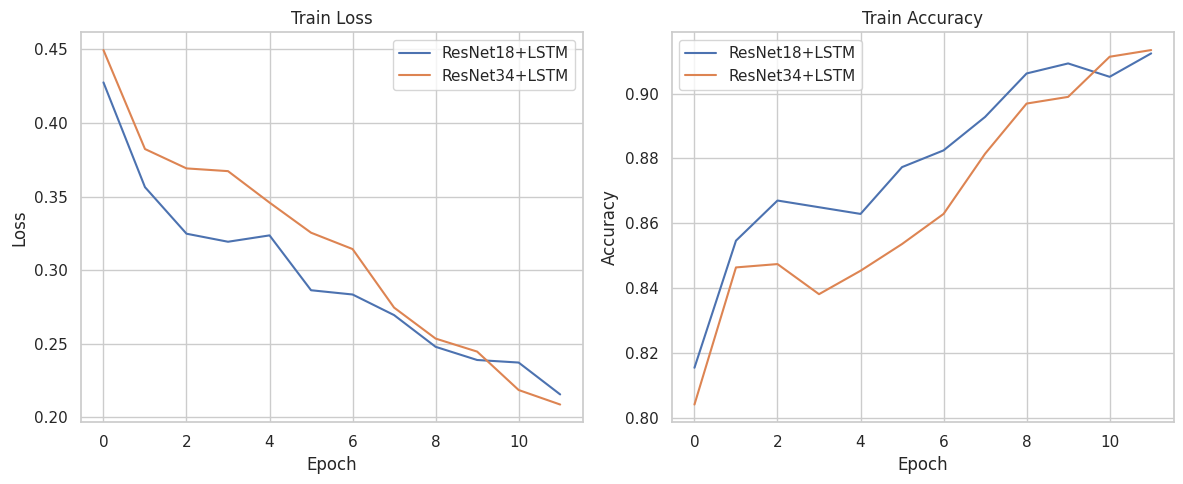

In [ ]:
# Loss and Acc, Resnet18/Resnet34 + LSTM
base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
resnet18_path = os.path.join(base_path, "v1_4.27_resnet18")
resnet34_path = os.path.join(base_path, "v1_4.28_resnet34")

def moving_average(arr, window_size=5):
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')

def load_and_smooth(path, label):
    loss = np.load(os.path.join(path, "train_losses.npy"), allow_pickle=True)
    acc = np.load(os.path.join(path, "train_accs.npy"), allow_pickle=True)
    return {
        "label": label,
        "loss": moving_average(loss, 5),
        "acc": moving_average(acc, 5)
    }

res18 = load_and_smooth(resnet18_path, "ResNet18+LSTM")
res34 = load_and_smooth(resnet34_path, "ResNet34+LSTM")

sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(res18["loss"], label=res18["label"])
plt.plot(res34["loss"], label=res34["label"])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(res18["acc"], label=res18["label"])
plt.plot(res34["acc"], label=res34["label"])
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

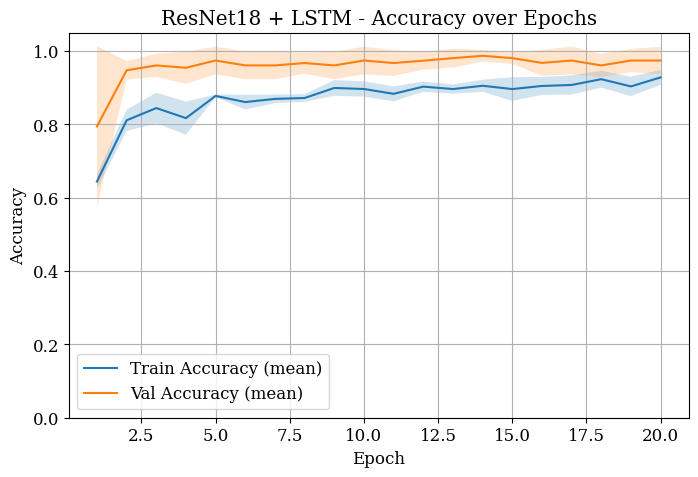

In [ ]:
# Mean acc, Resnet18+LSTM
base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
num_folds = 4
train_accs_list = []
val_accs_list = []


for fold_idx in range(1, num_folds + 1):
    fold_path = os.path.join(base_path, f"v1_6.17_resnet18lstm_fold_{fold_idx}")
    train_accs = np.load(os.path.join(fold_path, "train_accs.npy"))
    val_accs = np.load(os.path.join(fold_path, "val_accs.npy"))

    train_accs_list.append(train_accs)
    val_accs_list.append(val_accs)

train_accs_array = np.array(train_accs_list)
val_accs_array = np.array(val_accs_list)


train_mean = np.mean(train_accs_array, axis=0)
train_std = np.std(train_accs_array, axis=0)

val_mean = np.mean(val_accs_array, axis=0)
val_std = np.std(val_accs_array, axis=0)

epochs = np.arange(1, len(train_mean)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_mean, label='Train Accuracy (mean)')
plt.fill_between(epochs, train_mean-train_std, train_mean+train_std, alpha=0.2)

plt.plot(epochs, val_mean, label='Val Accuracy (mean)')
plt.fill_between(epochs, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.title('ResNet18 + LSTM - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.rcParams.update({'font.family': 'serif'})
plt.show()

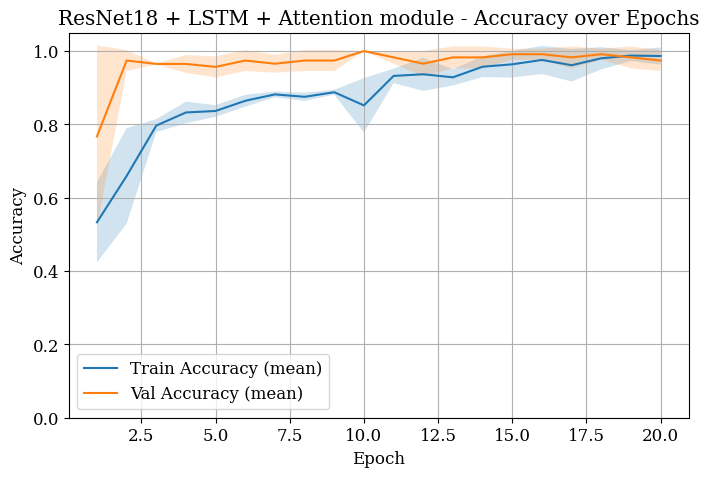

In [ ]:
# Mean Acc, Resnet18+LSTM+Attention
base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
num_folds = 4
train_accs_list = []
val_accs_list = []


for fold_idx in range(1, num_folds + 1):
    fold_path = os.path.join(base_path, f"v1_6.18_resnet18lstmattention_fold_{fold_idx}")
    train_accs = np.load(os.path.join(fold_path, "train_accs.npy"))
    val_accs = np.load(os.path.join(fold_path, "val_accs.npy"))

    train_accs_list.append(train_accs)
    val_accs_list.append(val_accs)

train_accs_array = np.array(train_accs_list)
val_accs_array = np.array(val_accs_list)


train_mean = np.mean(train_accs_array, axis=0)
train_std = np.std(train_accs_array, axis=0)

val_mean = np.mean(val_accs_array, axis=0)
val_std = np.std(val_accs_array, axis=0)

epochs = np.arange(1, len(train_mean)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_mean, label='Train Accuracy (mean)')
plt.fill_between(epochs, train_mean-train_std, train_mean+train_std, alpha=0.2)

plt.plot(epochs, val_mean, label='Val Accuracy (mean)')
plt.fill_between(epochs, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.title('ResNet18 + LSTM + Attention module - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.rcParams.update({'font.family': 'serif'})
plt.show()

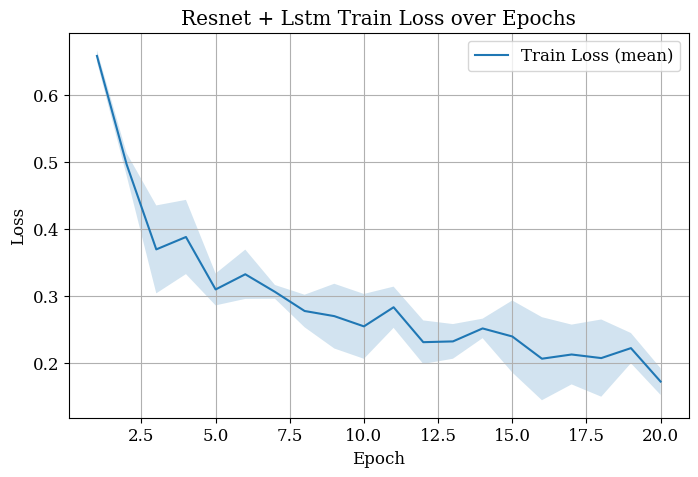

In [ ]:
# Mean loss, Resnet18+LSTM+Attention
import numpy as np
import os
import matplotlib.pyplot as plt

base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
num_folds = 4

train_losses_list = []

for fold_idx in range(1, num_folds + 1):
    fold_path = os.path.join(base_path, f"v1_6.17_resnet18lstm_fold_{fold_idx}")
    try:
        train_loss = np.load(os.path.join(fold_path, "train_losses.npy"), allow_pickle=True)
        train_losses_list.append(train_loss)
    except Exception as e:
        print(f"Error loading fold {fold_idx}: {e}")

if train_losses_list:
    train_losses = np.array(train_losses_list)  # shape: [folds, epochs]
    train_mean = train_losses.mean(axis=0)
    train_std = train_losses.std(axis=0)

    epochs = np.arange(1, len(train_mean) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_mean, label='Train Loss (mean)')
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.title('Resnet + Lstm Train Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.rcParams.update({'font.family': 'serif'})
    plt.show()

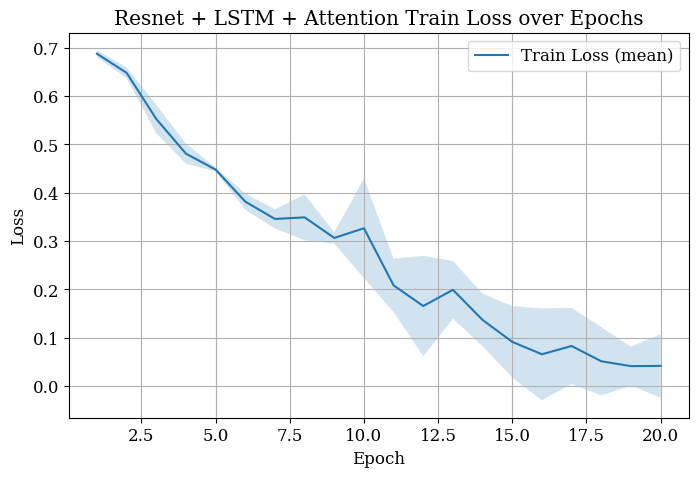

In [ ]:
# Mean loss, Resnet18+LSTM+Attention

base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
num_folds = 4

train_losses_list = []

for fold_idx in range(1, num_folds + 1):
    fold_path = os.path.join(base_path, f"v1_6.18_resnet18lstmattention_fold_{fold_idx}")
    try:
        train_loss = np.load(os.path.join(fold_path, "train_losses.npy"), allow_pickle=True)
        train_losses_list.append(train_loss)
    except Exception as e:
        print(f"Error loading fold {fold_idx}: {e}")

if train_losses_list:
    train_losses = np.array(train_losses_list)  # shape: [folds, epochs]
    train_mean = train_losses.mean(axis=0)
    train_std = train_losses.std(axis=0)

    epochs = np.arange(1, len(train_mean) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_mean, label='Train Loss (mean)')
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.title('Resnet + LSTM + Attention Train Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.rcParams.update({'font.family': 'serif'})
    plt.show()

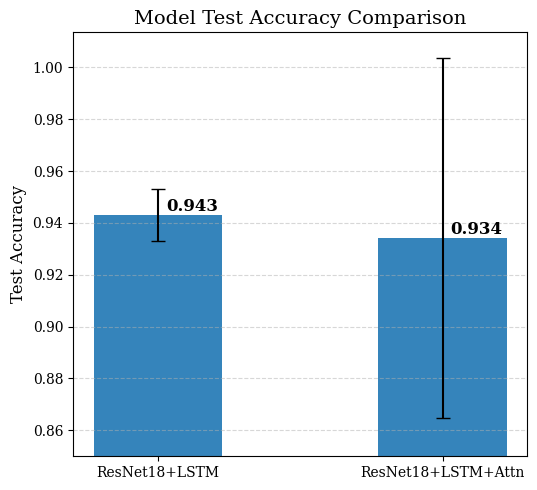

In [ ]:
# Acc Comparison
def extract_final_acc(acc_array):
    return next(x for x in reversed(acc_array) if x is not None)

model_configs = {
    "ResNet18+LSTM": {
        "path_fmt": "v1_6.17_resnet18lstm_fold_{}",
        "num_folds": 4
    },
    "ResNet18+LSTM+Attn": {
        "path_fmt": "v1_6.18_resnet18lstmattention_fold_{}",
        "num_folds": 4
    }
}

base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
model_accs = {}

for model_name, cfg in model_configs.items():
    accs = []
    for fold in range(1, cfg["num_folds"] + 1):
        path = os.path.join(base_path, cfg["path_fmt"].format(fold), "test_accs.npy")
        acc_array = np.load(path, allow_pickle=True)
        accs.append(extract_final_acc(acc_array))
    model_accs[model_name] = np.array(accs)

means = [np.mean(model_accs[m]) for m in model_accs]
stds  = [np.std(model_accs[m]) for m in model_accs]
labels = list(model_accs.keys())

plt.figure(figsize=(5.5,5))
bars = plt.bar(labels, means, yerr=stds, capsize=5, alpha=0.9, width=0.45)

plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Model Test Accuracy Comparison", fontsize=14)

for bar, mean in zip(bars, means):
    plt.text(
        bar.get_x() + bar.get_width()/2 + 0.12, bar.get_height(),
        f"{mean:.3f}",
        ha='center', va='bottom',
        fontsize=12, fontweight='bold', color='black'
    )

max_height = max(mean + std for mean, std in zip(means, stds))
plt.ylim(0.850, max_height + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

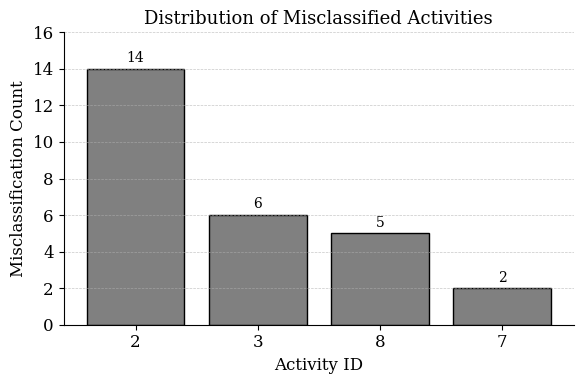

In [ ]:
# Distribution of Misclassified Activities
# misclassified samples are listed manually,
# because they are presented in the console log.
misclassified = [2, 2, 2, 3, 2, 2, 8, 2, 2, 2, 8, 8, 8, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 7, 7, 8]

counts = Counter(misclassified)
labels = list(counts.keys())
values = [counts[k] for k in labels]

plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar([str(l) for l in labels], values, color='gray', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.2,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel("Activity ID", fontsize=12)
ax.set_ylabel("Misclassification Count", fontsize=12)
ax.set_title("Distribution of Misclassified Activities", fontsize=13)
ax.set_ylim(0, max(values) + 2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

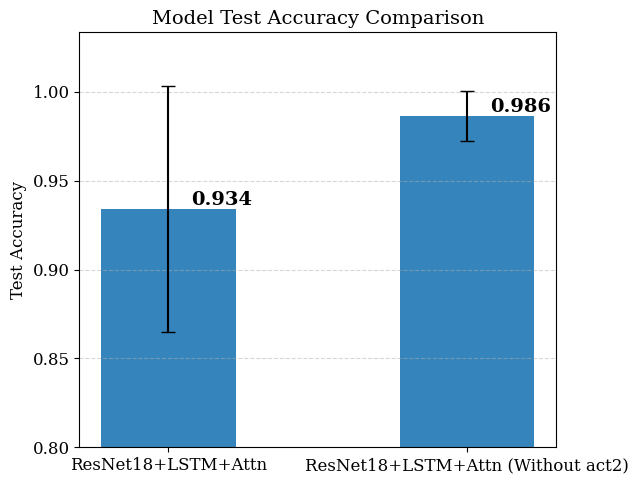

In [ ]:
# Acc Comparison
def extract_final_acc(acc_array):
    return next(x for x in reversed(acc_array) if x is not None)

model_configs = {
    "ResNet18+LSTM+Attn": {
        "path_fmt": "v1_6.18_resnet18lstmattention_fold_{}",
        "num_folds": 4
    },
    "ResNet18+LSTM+Attn (Without act2)": {
        "path_fmt": "v1_7.17_resnet18lstmattention_fold_{}",
        "num_folds": 4
    }
}

base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
model_accs = {}

for model_name, cfg in model_configs.items():
    accs = []
    for fold in range(1, cfg["num_folds"] + 1):
        path = os.path.join(base_path, cfg["path_fmt"].format(fold), "test_accs.npy")
        acc_array = np.load(path, allow_pickle=True)
        accs.append(extract_final_acc(acc_array))
    model_accs[model_name] = np.array(accs)

means = [np.mean(model_accs[m]) for m in model_accs]
stds  = [np.std(model_accs[m]) for m in model_accs]
labels = list(model_accs.keys())

plt.figure(figsize=(6.5,5))
bars = plt.bar(labels, means, yerr=stds, capsize=5, alpha=0.9, width=0.45)

plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Model Test Accuracy Comparison", fontsize=14)

for bar, mean in zip(bars, means):
    plt.text(
        bar.get_x() + bar.get_width()/2 + 0.18, bar.get_height(),
        f"{mean:.3f}",
        ha='center', va='bottom',
        fontsize=14, fontweight='bold', color='black'
    )

max_height = max(mean + std for mean, std in zip(means, stds))
plt.ylim(0.8, max_height + 0.03)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.rcParams.update({'font.family': 'serif'})
plt.show()

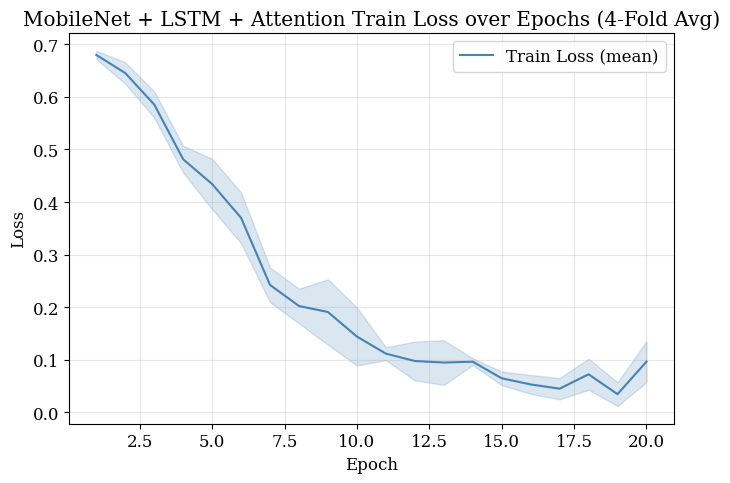

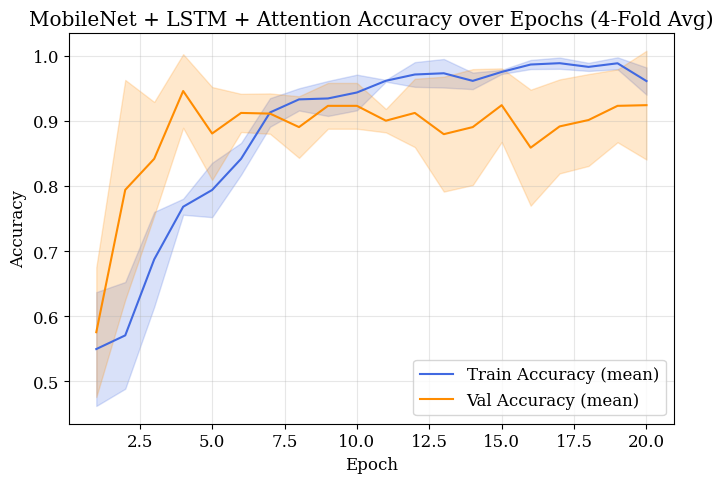

In [ ]:
# Acc and loss, mobilenet+lstm+attention

def load_curves(base_path, path_fmt, num_folds):
    all_train_losses = []
    all_train_accs = []
    all_val_accs = []

    for fold in range(1, num_folds + 1):
        fold_path = os.path.join(base_path, path_fmt.format(fold))
        train_losses = np.load(os.path.join(fold_path, "train_losses.npy"), allow_pickle=True)
        train_accs = np.load(os.path.join(fold_path, "train_accs.npy"), allow_pickle=True)
        val_accs   = np.load(os.path.join(fold_path, "val_accs.npy"), allow_pickle=True)

        all_train_losses.append([x if x is not None else np.nan for x in train_losses])
        all_train_accs.append([x if x is not None else np.nan for x in train_accs])
        all_val_accs.append([x if x is not None else np.nan for x in val_accs])

    return (
        np.array(all_train_losses),
        np.array(all_train_accs),
        np.array(all_val_accs)
    )

def plot_with_std(x, values, label, color):
    mean = np.nanmean(values, axis=0)
    std = np.nanstd(values, axis=0)
    plt.plot(x, mean, label=label, color=color)
    plt.fill_between(x, mean - std, mean + std, alpha=0.2, color=color)

# Load data
base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
path_fmt = "v1_7.1_MobileNetlstmattention_fold_{}"
num_folds = 4
train_losses, train_accs, val_accs = load_curves(base_path, path_fmt, num_folds)

epochs = np.arange(1, len(train_losses[0]) + 1)

# --- Plot 1: Train Loss ---
plt.figure(figsize=(7,5))
plot_with_std(epochs, train_losses, "Train Loss (mean)", "steelblue")
plt.title("MobileNet + LSTM + Attention Train Loss over Epochs (4-Fold Avg)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Accuracy ---
plt.figure(figsize=(7,5))
plot_with_std(epochs, train_accs, "Train Accuracy (mean)", "royalblue")
plot_with_std(epochs, val_accs, "Val Accuracy (mean)", "darkorange")
plt.title("MobileNet + LSTM + Attention Accuracy over Epochs (4-Fold Avg)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.rcParams.update({'font.family': 'serif'})
plt.show()

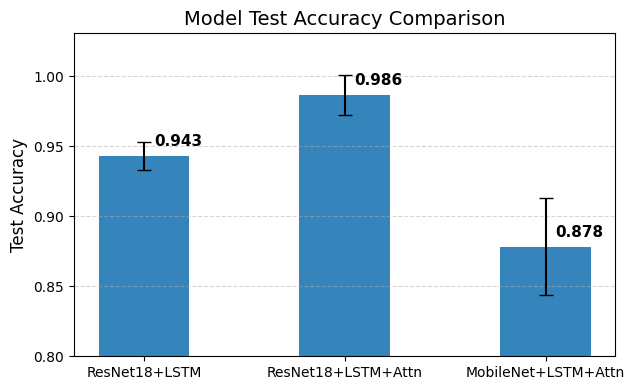

In [ ]:
#acc comparison

def extract_final_acc(acc_array):
    return next(x for x in reversed(acc_array) if x is not None)

model_configs = {
    "ResNet18+LSTM": {
        "path_fmt": "v1_6.17_resnet18lstm_fold_{}",
        "num_folds": 4
    },
    "ResNet18+LSTM+Attn": {
        "path_fmt": "v1_7.17_resnet18lstmattention_fold_{}",
        "num_folds": 4
    },
    "MobileNet+LSTM+Attn": {
        "path_fmt": "v1_7.1_MobileNetlstmattention_fold_{}",
        "num_folds": 4
    }
}

base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"
model_accs = {}

for model_name, cfg in model_configs.items():
    accs = []
    for fold in range(1, cfg["num_folds"] + 1):
        path = os.path.join(base_path, cfg["path_fmt"].format(fold), "test_accs.npy")
        acc_array = np.load(path, allow_pickle=True)
        accs.append(extract_final_acc(acc_array))
    model_accs[model_name] = np.array(accs)

means = [np.mean(model_accs[m]) for m in model_accs]
stds  = [np.std(model_accs[m]) for m in model_accs]
labels = list(model_accs.keys())

plt.figure(figsize=(6.5, 4))
bars = plt.bar(labels, means, yerr=stds, capsize=5, alpha=0.9,width = 0.45)

plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Model Test Accuracy Comparison", fontsize=14)


for bar, mean in zip(bars, means):
    plt.text(
        bar.get_x() + bar.get_width() / 2 + 0.17,
        bar.get_height() + 0.005,
        f"{mean:.3f}",
        ha='center', va='bottom',
        fontsize=11, fontweight='bold', color='black'
    )

max_height = max(mean + std for mean, std in zip(means, stds))
plt.ylim(0.8, max_height + 0.03)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.rcParams.update({'font.family': 'serif'})
plt.show()

In [ ]:
# inference settings
import time

def load_model(model_class, weight_path, device='cuda'):
    model = model_class()
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    return model.to(device)

base_path = "/content/drive/My Drive/Colab Notebooks/smarthomefalldetection/results"

model_configs = {
    "ResNet34": {
        "class": ResNet34LSTMClassifier,
        "path": f"{base_path}/v1_4.28_resnet34/model.pth"
    },
    "ResNet18+LSTM": {
        "class": ResNetLSTMClassifier,
        "path": f"{base_path}/v1_6.17_resnet18lstm_fold_4/model.pth"
    },
    "ResNet18+LSTM+Attn": {
        "class": ResNetLSTMAttentionClassifier,
        "path": f"{base_path}/v1_7.17_resnet18lstmattention_fold_2/model.pth"
    },
    "MobileNet+LSTM+Attn": {
        "class": MobileNetLSTMAttentionClassifier,
        "path": f"{base_path}/v1_7.1_MobileNetlstmattention_fold_2/model.pth"
    },
}

# Prepare data (per batch)
B, T, C, H, W = 2, 300, 3, 224, 224
dummy_input = torch.randn(B, T, C, H, W).cuda()
dummy_lengths = torch.tensor([T]*B).cuda()

def benchmark_inference(model, input_tensor, lengths, repeat=10):
    with torch.no_grad():
        torch.cuda.synchronize()
        start = time.time()
        for _ in range(repeat):
            _ = model(input_tensor, lengths)
        torch.cuda.synchronize()
        end = time.time()
    return (end - start) / repeat


results = {}

Loading: ResNet34
ResNet34: 0.1044 s
Loading: ResNet18+LSTM
ResNet18+LSTM: 0.0663 s
Loading: ResNet18+LSTM+Attn
ResNet18+LSTM+Attn: 0.0668 s
Loading: MobileNet+LSTM+Attn
MobileNet+LSTM+Attn: 0.0986 s


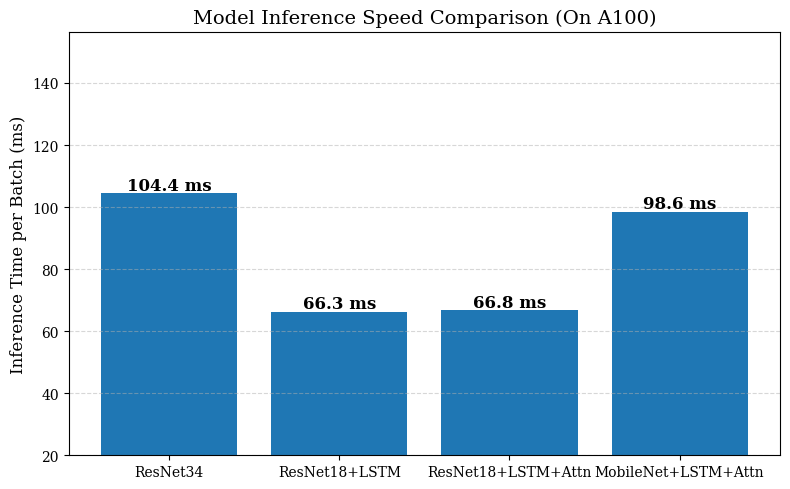

In [ ]:
# inference speed comparison on A100
for name, cfg in model_configs.items():
    print(f"Loading: {name}")
    model = load_model(cfg["class"], cfg["path"])
    avg_time = benchmark_inference(model, dummy_input, dummy_lengths)
    results[name] = avg_time
    print(f"{name}: {avg_time:.4f} s")

plt.figure(figsize=(8,5))
names = list(results.keys())
times = [results[k]*1000 for k in names]
bars = plt.bar(names, times)
plt.ylabel("Inference Time per Batch (ms)", fontsize=12)
plt.title("Model Inference Speed Comparison (On A100)", fontsize=14)
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1,
             f"{t:.1f} ms", ha='center', fontsize=12, fontweight='bold')
plt.ylim(20, max(times)*1.50)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.rcParams.update({'font.family': 'serif'})
plt.show()

Loading: ResNet18+LSTM
ResNet18+LSTM peak GPU memory: 4073.5 MiB
Loading: ResNet18+LSTM+Attn
ResNet18+LSTM+Attn peak GPU memory: 4073.8 MiB
Loading: MobileNet+LSTM+Attn
MobileNet+LSTM+Attn peak GPU memory: 6336.6 MiB


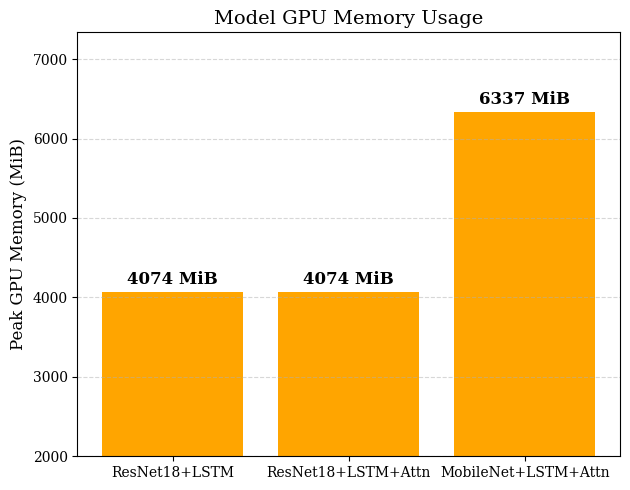

In [ ]:
# Peak Memory Comparison
def benchmark_peak_memory(model, input_tensor, lengths):
    torch.cuda.reset_peak_memory_stats()
    with torch.no_grad():
        _ = model(input_tensor, lengths)
    peak_mem = torch.cuda.max_memory_allocated() / 1024 / 1024
    return round(peak_mem, 1)

mem_results = {}
for name, cfg in model_configs.items():
    if name == "ResNet34":
        continue
    print(f"Loading: {name}")
    model = load_model(cfg["class"], cfg["path"])
    mem = benchmark_peak_memory(model, dummy_input, dummy_lengths)
    mem_results[name] = mem
    print(f"{name} peak GPU memory: {mem:.1f} MiB")

plt.figure(figsize=(6.4,5))
names = list(mem_results.keys())
mems = [mem_results[k] for k in names]
bars = plt.bar(names, mems, color='orange')

plt.ylabel("Peak GPU Memory (MiB)", fontsize=12)
plt.title("Model GPU Memory Usage", fontsize=14)

for bar, m in zip(bars, mems):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+100,
             f"{m:.0f} MiB", ha='center', fontsize=12, fontweight='bold')

plt.ylim(2000, max(mems) + 1000)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()